# Effective spin control: pulse design & state evolution

This tutorial shows how to construct effective spin parameter pulses (g-factors, exchange, ESR field) for basic quantum gates using Constrained Shape Pulse algorithm (see [Chapter 4 of Bohdan's thesis](https://uwspace.uwaterloo.ca/handle/10012/17823) for theory).

The outline of each test case is as follows:
1. Creating **spin states**: initial and expected after evolution for comparison

2. Choosing effective parameter **shape functions**
3.  Creating **DesignerEffective** objects, which contain 
        the in-built pulse design method
4. Composing **pulse sequences** out of designer objects
5. Performing **spin density matrix evolution** and plotting parameters:
    - fidelity 
    - purity
    - 1-qubit subspace evolution on the Bloch spheres

The steps above are discussed in detail for a selective qubit rotation.
At the end of the tutorial, the entire effective pulse design and evolution routine is demonstrated for
$\mathrm{SWAP}^k$ and CPHASE gates, and the effects of spin relaxation and dephasing.


> Necessary imports and default plotting parameters:

In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())

# update base working directory to QuDiPy
if path.stem != 'QuDiPy':
    print(path.parents[1])

    base_dir = path.parents[1]
    os.chdir(base_dir)
else:
    base_dir = path

c:\mainCSG.github.io\QuDiPy


In [2]:
import numpy as np
from matplotlib import pyplot as plt

from qudipy.system import State
from qudipy.design import effective, shapes

## 1. Addressing individual spins in the global ESR field
The goal of this section is to demonstrate selective rotation of the 1st 
qubit of a 2-qubit system:

$$  
    Y_1\left(\frac{\pi}{2}\right)
    |\uparrow -\rangle = |+ -\rangle
$$


### 1.1 Defining spin states using `State` class

The  `State`  class from `qudipy.system.state` handles many-electron states in different spaces:
- spin 
- orbital
- valley
- Hubbard (spin + charge)

Currently, only spin states are handled. Defining some basic 1-qubit spin wavefunctions:

In [3]:
psi_up =  np.array([1,0])                           # pure spin up state
psi_down =  np.array([0,1])                         # pure spin down state
psi_plus = 1/np.sqrt(2) * np.array([1,1])           # pure |+> state
psi_minus =  1/np.sqrt(2) * np.array([1,-1])        # pure |-> state

The system of spins is described by the complex density matrix $\rho$ whose evolution is of interest.

Several ways to define the spin state of `State` object are supported through `spin` keyword:
- the density matrix of the whole system: square 2D array;
- the wavefunction (**ket**-vector) of a pure state: row or column vector as 1D/2D array;
- a list/tuple of density matrices, wavefunctions, or both, that describe subsystems constituting the whole system.

The density matrix of the whole system is generated and stored automatically irrespective of the type of input. 

The number of electrons in the system $N$ is inferred from the size of $\rho$; if it changes over time (e.g. due to measurements), the parameter $N_0$ should be specified to indicate the maximal possible electron number. Otherwise, the equality $N=N_0$ is assumed.

The environment parameters that can be specified as State object attributes include:
- temperature (`T` keyword, $0$ K by default)
- $T_1$, $T_2$ times  (`T_1, T_2` keywords, $\infty$ by default).

For now, we assume no dissipation.

In [4]:
# defining states: initial and expected
# init_rot = State([psi_up, psi_down, psi_minus])
# exp_rot = State([psi_plus, psi_down, psi_minus])

init_rot = State([psi_up, psi_minus])
exp_rot = State([psi_plus,  psi_minus])

### 1.2 Creating or selecting shape functions

The shape function that defines the effective pulses can be any function of normalized time
with unit expectation value:
$$
    S(\tau): [0,1]\rightarrow \mathbb{R}: \qquad  \langle S \rangle = \int_0^1 S(\tau) \mathrm{d}\tau = 1.
$$

The library of pre-defined shapes includes square, triangular and Gaussian functions. 
They can be either:
- accessed through `qudipy.design.shapes` module, _or_
- specified as 'string keywords' when creating a `DesignerEffective` or `ControlPulse` objects (see next)

Defining 4 different shape functions:

In [5]:
unit_square = shapes.square()
unit_triangle = shapes.triangle()
unit_wide_gauss = shapes.gaussian(sigma=0.3)
unit_narrow_gauss = shapes.gaussian(sigma=0.1)

list_shapes = [unit_square, unit_triangle, unit_narrow_gauss, unit_wide_gauss]

Plotting these shapes:

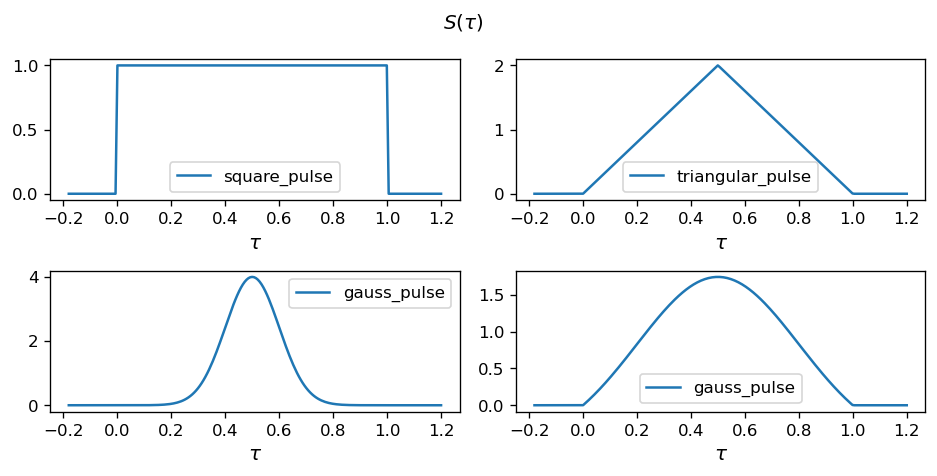

In [6]:
# Normalized time points
tau = np.linspace(-0.18, 1.2, 200)

fig, ax = plt.subplots(2,2, figsize=(8,4), dpi=120)
for i, shape in enumerate(list_shapes):
    ax[i//2, i%2].plot(tau , shape(tau), label=shape.__name__)
    ax[i//2, i%2].legend()
    
    # Setting axes labels.
    ax[i//2, i%2].set_xlabel('$\\tau$', size=12)
    
fig.suptitle('$S(\\tau)$', size=12)
fig.tight_layout()
plt.show()

### 1.3 Constructing DesignerEffective objects

`Designer` class and its child `DesignerEffective` handle control parameters that determine time-dependent pulse sequences. 
The functions that construct DesignerEffective objects for:
-  arbitrary qubit rotations (`rot`), 
- Hadamard gates (`hadamard`),
- $\mathrm{SWAP}^k$ gates (`swapk`), and
- CPHASE gates (`cphase`),

are defined in `qudipy.design.effective` module.

All designer-like objects require these parameters in advance 
to determine the idling state and the rotating frame: 
1. g-factor of idling qubits,
and 
2. ___either___ Zeeman field [T] ___or___ ESR central frequency [Hz]

In [7]:
g_idle = 1.99
B_zeeman = 1  # tesla

Building up a designer for synchronous  rotations of the 1st qubit 
in a 2-qubit system by an angle $-3 \pi/8$. 
The cumulative effect of such 4 pulses will give a $-3 \pi/2 \equiv \pi/2$ rotation.
Any other combination of angles that gives total angle $\pi/2 \mod 2\pi$ can be used.

In [8]:
rot_des = effective.rot(N=3, qubits = 1, axis = 'Y', angle = - 3 * np.pi/8, 
                                        g_idle = g_idle, B_zeeman = B_zeeman)

# One Hadamard operation will transform the chosen state as a Y(\pi/2) rotation,
# and thus can be used instead

# rot_des = effective.hadamard(3, (1,), g_idle=g_idle, B_zeeman=B_zeeman)

### 1.3 Composing ControlPulse objects using a designer

Objects from `Designer` family can be used to compose time-dependent pulses with different shapes, lengths, and
constraints (min/max values of parameters, bandwitdth, etc.)

In particular, each call of `compose` method requires specification of the following parameters:
- chosen shape function/string `shape`,
- number of time steps  `num_steps`, and
- pulse length (in seconds) `length`. 

If the constraints are additionally provided as extra keyword parameters, a key `length='optimize'` will 
find the shortest possible pulse length automatically ***(does not work for now)***

Below, we compose four `ControlPulse` objects
 with **different shapes** and same length $T=1\mu s$ that correspond to the same $Y_1(-\frac{3\pi}{8})$
operation. 

In [9]:
train_pulses = [rot_des.compose(shape=sh, length=1e-6, num_steps=1600) 
                                                        for sh in list_shapes]

For all effective pulses we design here, 
the physical quantities that could vary over time include:  
- RF magnetic field magnitude `"B_rf"` and phase `"phi"` (in rotation frame)
- Deviation g-factor of the $i^{th}$ electron `"delta_g_{i}"`
- Exchange couplings between the $i^{th}$ and $(j)^{th}$ electrons `"J_{ij}"`

Plotting each of the effective pulses (`B_rf` is measured in tesla here):

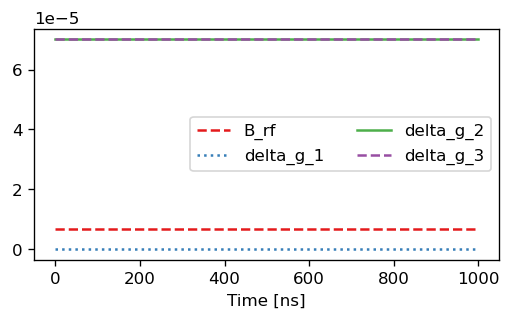

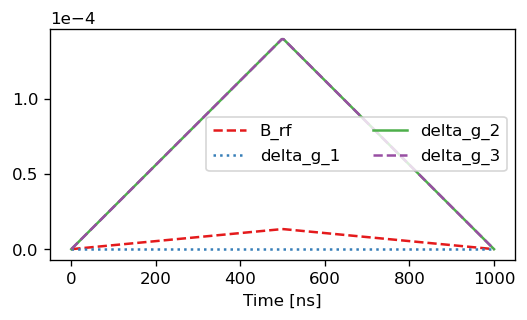

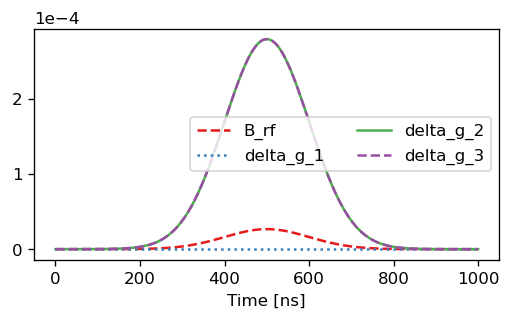

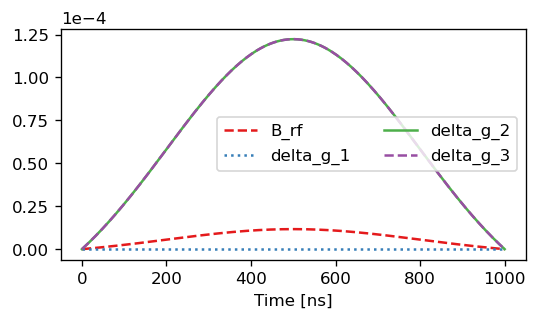

In [10]:
[pulse.plot(plot_ctrls=['B_rf', 'delta_g_1', 'delta_g_2', 'delta_g_3']) 
                                                    for pulse in train_pulses]
plt.show()

### 1.4 Evolving spin systems

The method `evolve` of a `State` object simulates the system evolution under a given pulse or iterable (tuple or list) of pulses. The iterable could be irregular, like, for example, `[pulse1, pulse2, [pulse3, (pulse4, pulse5)], pulse6]`. It returns a dictionary of 1D arrays of the user-specified parameters that are monitored throughout the simulation:
- Purity of the density matrix 
    - Evaluated when `eval_purity=True` is specified
    - `"purity"` entry in the resultant dictionary  
- Fidelity of the density matrix with respect to the theoretical (initial,expected final, etc.) matrix
    - Evaluated when `eval_fidelity=True` and the reference matrix `rho_reference` are specified
    - `"fidelity"` entry in the resultant dictionary  
- 1-electron density submatrices 
    - Evaluated when a qubit / iterable of qubits to track `track_qubits` is specified
    - `"submatrix_{i}"` entry in the resultant dictionary  
-  Bloch vector components $\langle \sigma_{x} \rangle, \langle \sigma_{y} \rangle, \langle \sigma_{z} \rangle$
    - Evaluated when `eval_Bloch_vectors=True` and an iterable of qubits to track `track_qubits` are specified
    - `"sigma_x_{i}"`,`"sigma_y_{i}"`, `"sigma_z_{i}"` entries in the resultant dictionary  
    
The other entry in the final dictionary, `"time"`, incorporates all points in time during the simulation.

An optional parameter `track_points_per_pulse` could be used to record only a part of the parameter values during the pulse to save memory (default is 100). In particular, it could be equated to 2 if one wants to record only the parameters before and after each pulse.

You can monitor the system evolution with the progress bars. If the system evolves under a sequence of pulses, the bars appear for each of them individually.

Here, we evolve system under four $\pi/8$ pulses with different shapes designed above to obtain a $\pi/2$ rotation.


In [11]:
rot_data = init_rot.evolve(train_pulses, rho_reference= exp_rot.rho_spin,
                           track_qubits=(1,2), eval_fidelity=True,
                                    eval_Bloch_vectors=True)

ROTY-67.50° 1, step 1600: 100%|██████████| 1600/1600 [00:04<00:00, 329.97it/s]


Plotting evolution results

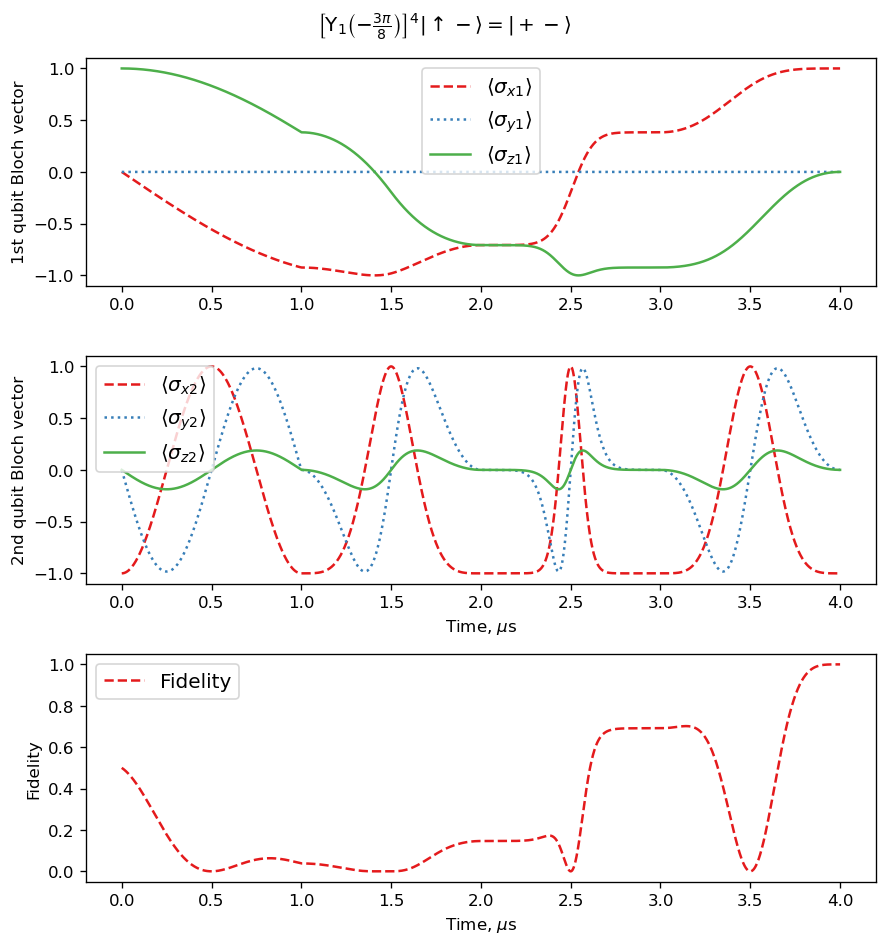

In [12]:
%matplotlib inline

fig, ax = plt.subplots(3,1, dpi=120, figsize=(7.5,8) )


ax[0].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_x_1"]), label="⟨$\sigma_{x1}$⟩")
ax[0].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_y_1"]), label="⟨$\sigma_{y1}$⟩") 
ax[0].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_z_1"]), label="⟨$\sigma_{z1}$⟩")

ax[0].set_ylabel("1st qubit Bloch vector")
ax[0].legend( fontsize="large")

###############################

ax[1].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_x_2"]), label="⟨$\sigma_{x2}$⟩")
ax[1].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_y_2"]), label="⟨$\sigma_{y2}$⟩") 
ax[1].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_z_2"]), label="⟨$\sigma_{z2}$⟩")

ax[1].set_xlabel("Time, $\mu$s")
ax[1].set_ylabel("2nd qubit Bloch vector")

ax[1].legend( fontsize="large")

############

ax[2].plot(rot_data["time"] * 1e6, 
         np.real(rot_data['fidelity']), label="Fidelity")
ax[2].set_xlabel("Time, $\mu$s")
ax[2].set_ylabel("Fidelity")

ax[2].legend(fontsize="large")

fig.suptitle('$\\left[\\mathrm{Y}_{1}\\left(-\\frac{3\\pi}{8}\\right)\\right]^4$'
             '$ |\\uparrow -\\rangle = |+ -\\rangle$')
plt.tight_layout()
plt.show()

Note the $2\pi$ rotations around skewed axes that non-resonant qubit #3 goes through to preserve 
its initial states after each pulse.

Fidelity at the end:

In [13]:
rot_data['fidelity'][-1]

1.0000000192124725

## $\mathrm{SWAP}^k$ two-qubit gates

This and the following sections show how to quickly run everything altogether: state definition, pulse design, and state evolution.

Testing the operation $\mathrm{SWAP}_{12} |+ \uparrow -\rangle = |\uparrow + -\rangle$ with 
four $\mathrm{SWAP}^{1/4}$ pulses of different lengths.

> Initial and expected states:

In [14]:
init_swap = State(spin=[psi_plus, psi_up, psi_minus])
exp_swap = State(spin=[psi_up, psi_plus, psi_minus])

> DesignerEffective objects for $\mathrm{SWAP}^{1/4}$ pulses

In [15]:
swap_des = effective.swapk(3, (1,2), k=1/4, g_idle=g_idle, B_zeeman = B_zeeman)

> Composing pulses with **different lengths** $T = 10, 20, 50, 100$ ns 
> and same shape (gaussian with $\sigma=0.2$)

In [16]:
train_swap_pulses = [swap_des.compose(shape='gaussian',  length=T, num_steps = 500,sigma=0.2) 
                            for T in [1e-8, 2e-8, 5e-8, 1e-7]]

> Evolving qubit state, plotting fidelity and Bloch vectors

In [17]:
swap_data = init_swap.evolve(train_swap_pulses, rho_reference=exp_swap.rho_spin, 
                            eval_fidelity=True, track_qubits=(1,2,3), 
                                    eval_Bloch_vectors=True)

SWAP^0.25 (1, 2), step 500: 100%|██████████| 500/500 [00:03<00:00, 135.50it/s]


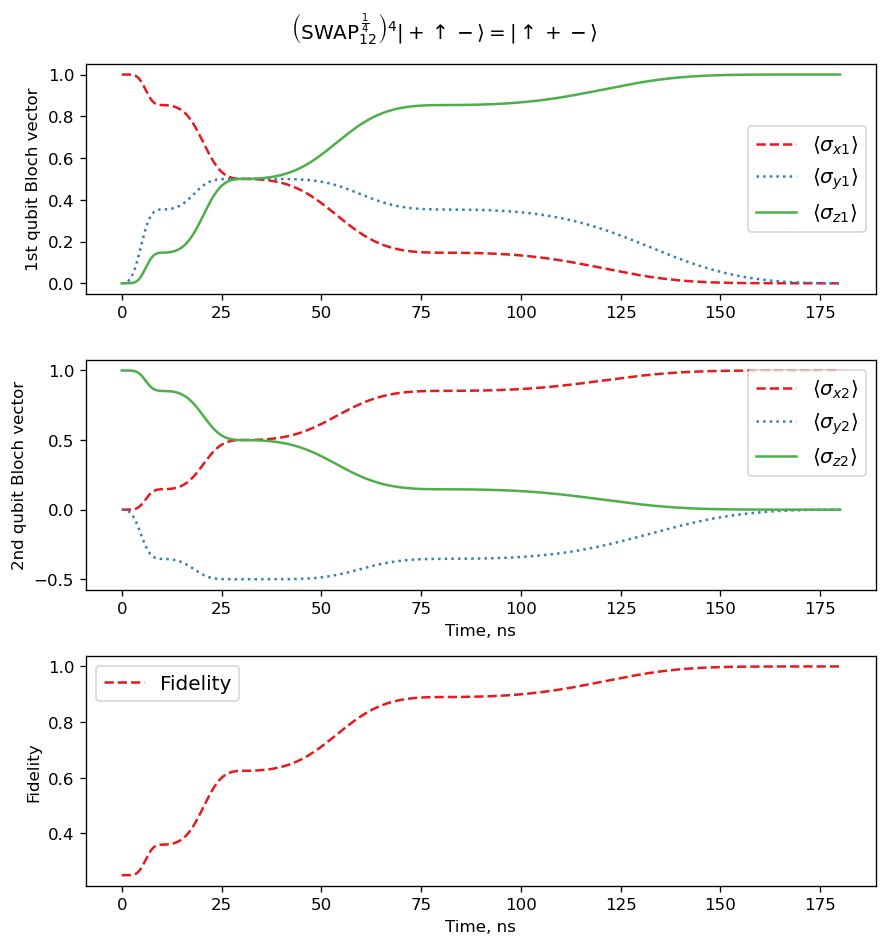

In [18]:
fig, ax = plt.subplots(3,1, dpi=120, figsize=(7.5,8) )


ax[0].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_x_1"]), label="⟨$\sigma_{x1}$⟩")
ax[0].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_y_1"]), label="⟨$\sigma_{y1}$⟩") 
ax[0].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_z_1"]), label="⟨$\sigma_{z1}$⟩")

ax[0].set_ylabel("1st qubit Bloch vector")
ax[0].legend( fontsize="large")

###############################

ax[1].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_x_2"]), label="⟨$\sigma_{x2}$⟩")
ax[1].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_y_2"]), label="⟨$\sigma_{y2}$⟩") 
ax[1].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_z_2"]), label="⟨$\sigma_{z2}$⟩")

ax[1].set_xlabel("Time, ns")
ax[1].set_ylabel("2nd qubit Bloch vector")

ax[1].legend(fontsize="large")

############

ax[2].plot(swap_data["time"] * 1e9, 
         np.real(swap_data['fidelity']), label="Fidelity")
ax[2].set_xlabel("Time, ns")
ax[2].set_ylabel("Fidelity")

ax[2].legend(fontsize="large")

fig.suptitle('$\\left(\\mathrm{SWAP}^{\\, \\frac{1}{4}}_{12}\\right)^4 \
             |+ \\uparrow -\\rangle = |\\uparrow + -\\rangle$')
plt.tight_layout()
plt.show()

Fidelity at the end:

In [19]:
swap_data['fidelity'][-1]

0.9999999999987618

## 3. $\mathrm{CPHASE}(\alpha)$ two-qubit gates


Running two control-Z operations in parallel on a 4-qubit system:

 $$\mathrm{CZ}_{12} \mathrm{CZ}_{34}| + \downarrow \downarrow - \rangle = | - \downarrow \downarrow +\rangle$$ 

We represent each gate control-Z gate as a combination of two control-phase gates:
$$
    \mathrm{CZ} = \mathrm{CPHASE}(\pi) = \mathrm{CPHASE}(\pi/3) \mathrm{CPHASE}(2\pi/3)
$$

> Initial and expected states:

In [20]:
init_cz = State(spin=[ psi_plus, psi_down, psi_down, psi_minus])
exp_cz = State(spin=[ psi_minus, psi_down, psi_down, psi_plus])

> Two DesignerEffective objects for $\mathrm{CPHASE}$ pulses. 
> Specifying all parameters, including shapes and times, right away this time

In [21]:
cphase_pi3_des = effective.cphase(4, [(1,2),(3,4)], angle = np.pi/3,
                                  g_idle=g_idle, B_zeeman = B_zeeman,)
                                  
cphase_2pi3_des = effective.cphase(4, [(1,2),(3,4)], angle = 2* np.pi/3, 
                                    g_idle=g_idle, B_zeeman = B_zeeman,)

> Composing corresponding pulses 

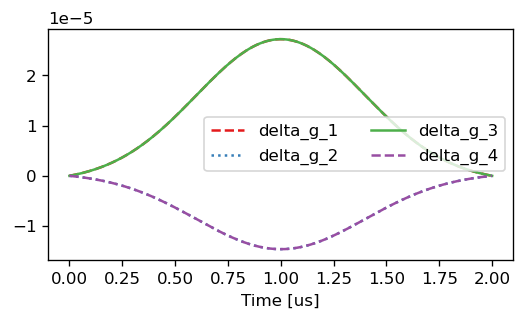

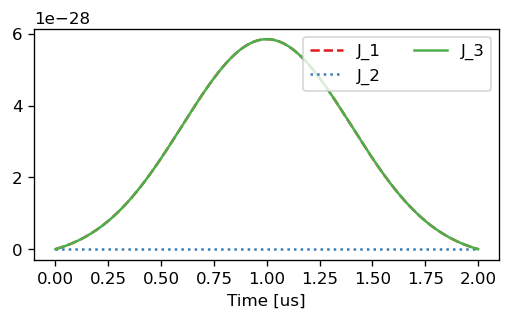

In [22]:
cphase_pulses = [cphase_pi3_des.compose('gaussian', 500, length = 2e-6, sigma=0.2), 
                cphase_2pi3_des.compose('triangle', 500, length = 3e-6)]

#plotting first pulse
cphase_pulses[0].plot(plot_ctrls=['delta_g_1', 'delta_g_2', 'delta_g_3', 'delta_g_4'])
cphase_pulses[0].plot(plot_ctrls=['J_1','J_2','J_3'])

> Evolving qubit state, plotting fidelity and Bloch vectors

In [23]:
cphase_data = init_cz.evolve(cphase_pulses, rho_reference=exp_cz.rho_spin, 
                            eval_fidelity=True, track_qubits=(1,2,3), 
                                    eval_Bloch_vectors=True)

CPHASE(120.00°) (1, 2) (3, 4), step 500: 100%|██████████| 500/500 [00:12<00:00, 39.59it/s]


Plotting Bloch vector evolution of the qubits 1,2,3

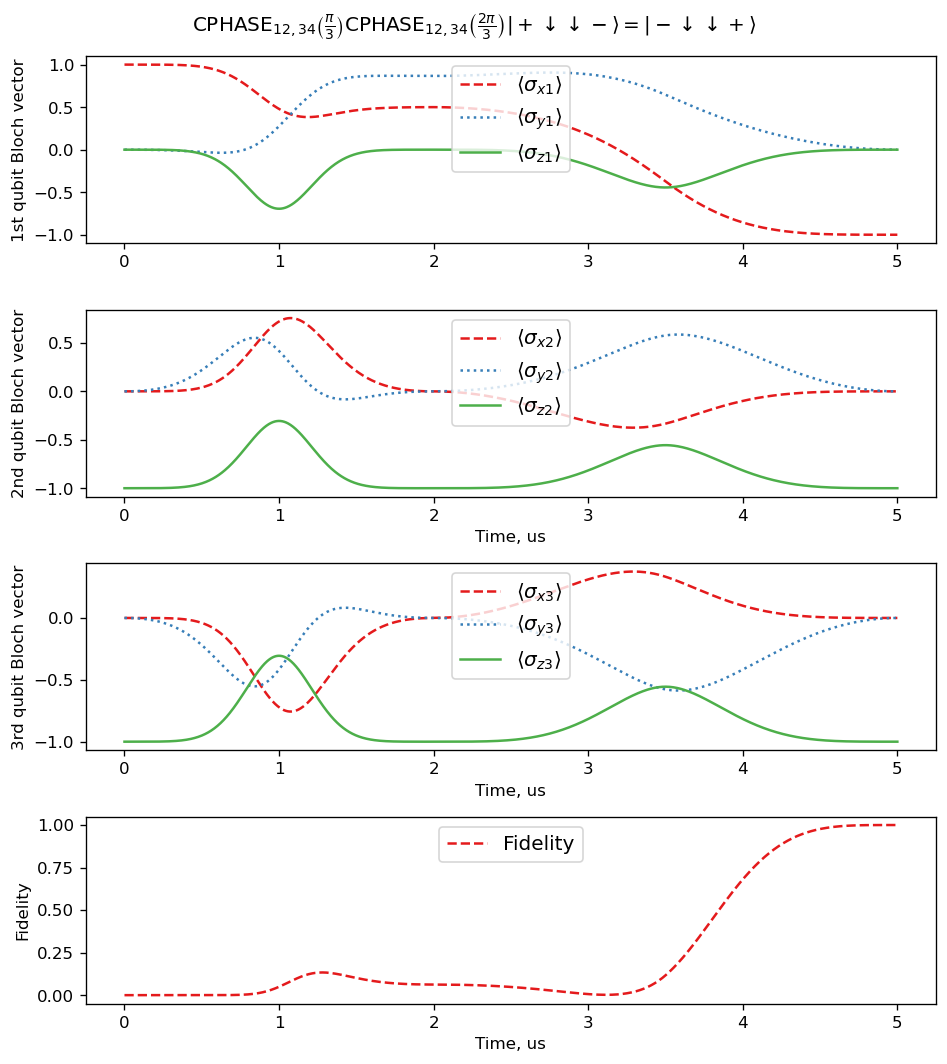

In [24]:
fig, ax = plt.subplots(4,1, dpi=120, figsize=(8,9) )

ax[0].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_x_1"]), label="⟨$\sigma_{x1}$⟩")
ax[0].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_y_1"]), label="⟨$\sigma_{y1}$⟩") 
ax[0].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_z_1"]), label="⟨$\sigma_{z1}$⟩")

ax[0].set_ylabel("1st qubit Bloch vector")
ax[0].legend(loc='upper center',  fontsize="large")

###############################

ax[1].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_x_2"]), label="⟨$\sigma_{x2}$⟩")
ax[1].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_y_2"]), label="⟨$\sigma_{y2}$⟩") 
ax[1].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_z_2"]), label="⟨$\sigma_{z2}$⟩")

ax[1].set_xlabel("Time, us")
ax[1].set_ylabel("2nd qubit Bloch vector")

ax[1].legend(loc='upper center', fontsize="large")

###############################

ax[2].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_x_3"]), label="⟨$\sigma_{x3}$⟩")
ax[2].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_y_3"]), label="⟨$\sigma_{y3}$⟩") 
ax[2].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_z_3"]), label="⟨$\sigma_{z3}$⟩")

ax[2].set_xlabel("Time, us")
ax[2].set_ylabel("3rd qubit Bloch vector")

ax[2].legend(loc='upper center', fontsize="large")

############

ax[3].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data['fidelity']), label="Fidelity")
ax[3].set_xlabel("Time, us")
ax[3].set_ylabel("Fidelity")

ax[3].legend(loc='upper center', fontsize="large")

fig.suptitle('$\\mathrm{CPHASE}_{12, 34}\\left(\\frac{\\pi}{3}\\right)$'
             '$ \\mathrm{CPHASE}_{12, 34}\\left(\\frac{2\\pi}{3}\\right) $'
             '$| + \\downarrow\\downarrow - \\rangle = |- \\downarrow\\downarrow + \\rangle$')

plt.tight_layout()
plt.show()

Fidelity at the end:

In [25]:
cphase_data['fidelity'][-1]

0.999999999248224